# Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import neighbors
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, f1_score

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
data = pd.read_csv("/content/sample_data/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv")

In [3]:
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [4]:
data.shape

(9134, 24)

## Data Analysis

In [0]:
data_categ = data.select_dtypes(include=["object"])
data_num = data.select_dtypes(exclude=["object"])

In [6]:
data_categ.columns

Index(['Customer', 'State', 'Response', 'Coverage', 'Education',
       'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code',
       'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type',
       'Sales Channel', 'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [7]:
data_categ.dtypes

Customer             object
State                object
Response             object
Coverage             object
Education            object
Effective To Date    object
EmploymentStatus     object
Gender               object
Location Code        object
Marital Status       object
Policy Type          object
Policy               object
Renew Offer Type     object
Sales Channel        object
Vehicle Class        object
Vehicle Size         object
dtype: object

In [8]:
data_categ.shape

(9134, 16)

In [9]:
data_num.dtypes

Customer Lifetime Value          float64
Income                             int64
Monthly Premium Auto               int64
Months Since Last Claim            int64
Months Since Policy Inception      int64
Number of Open Complaints          int64
Number of Policies                 int64
Total Claim Amount               float64
dtype: object

In [10]:
data_num.shape

(9134, 8)

In [0]:
data = data.drop(columns={"Customer","Policy", "Effective To Date"})

In [12]:
# Define a list with all features which are categorial

data_categorial = data.select_dtypes(include=["object"])
categories = list(data_categorial.columns)
categories

['State',
 'Response',
 'Coverage',
 'Education',
 'EmploymentStatus',
 'Gender',
 'Location Code',
 'Marital Status',
 'Policy Type',
 'Renew Offer Type',
 'Sales Channel',
 'Vehicle Class',
 'Vehicle Size']

In [0]:
# Encode the categorial Data to numerical

lb = LabelEncoder()

for i in categories:
    data[i] = lb.fit_transform(data[i])


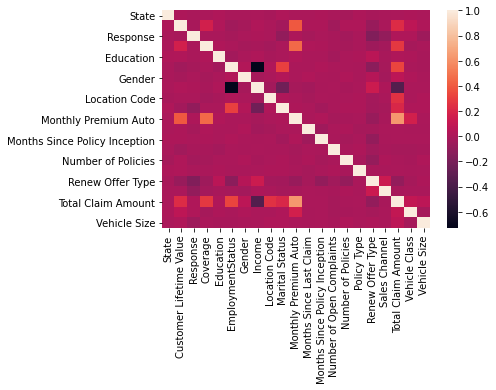

In [14]:
sns.heatmap(data.corr())

# Supervised Machine Learning with balanced data

In [0]:
y = data["Response"]

In [0]:
X = data.drop(["Response"], axis=1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=29)

## Downsampling of the data

In [18]:
# concatenate our training data back together

X_down = pd.concat([X_train, y_train], axis=1)

# separate converted and not converted

conv_no = X_down[X_down.Response==0]
conv_yes = X_down[X_down.Response==1]

# downsample majority

conv_no_downsampled = resample(conv_no,
                               replace = False, # sample without replacement
                               n_samples = len(conv_yes), # match minority n
                               random_state = 27) # reproducible results

# combine minority and downsampled majority

downsampled = pd.concat([conv_no_downsampled, conv_yes])

# checking counts

downsampled.Response.value_counts()

1    1033
0    1033
Name: Response, dtype: int64

In [19]:
downsampled.shape

(2066, 21)

In [0]:
y_train_down = downsampled.Response

In [0]:
X_train_down = downsampled.drop(["Response"], axis = 1)

## Logistic regression

In [22]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
# initialize the model (=lr)

lr.fit(X_train_down,y_train_down)
#fit the model to the train set

y_pred_lr = lr.predict(X_test)

lr_acc_test = lr.score(X_test,y_test)*100
lr_acc_train = lr.score(X_train_down,y_train_down)*100
# comparing the test with the data

print("Logistic Regression Test Accuracy", round(lr_acc_test, 2),"%")
print("Logistic Regression Train Accuracy", round(lr_acc_train, 2),"%")

Logistic Regression Test Accuracy 50.96 %
Logistic Regression Train Accuracy 53.58 %


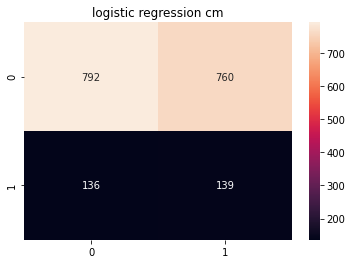

In [23]:
cm = metrics.confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt="d").set_title("logistic regression cm")
plt.show()

In [24]:
lr_recall = recall_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test,y_pred_lr)
lr_f1 = f1_score(y_test,y_pred_lr)

print("lr_recall is",(lr_recall))
print("lr_precision is",(lr_precision))
print("lr_f1 score is",(lr_f1))

lr_recall is 0.5054545454545455
lr_precision is 0.1546162402669633
lr_f1 score is 0.23679727427597957


In [43]:
y_pred_lr.shape

(1827,)

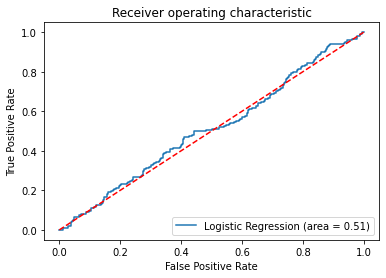

In [25]:
# ROC Curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Decision Tree

In [26]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_down, y_train_down)

y_pred_dtc = dtc.predict(X_test)

acc_train = dtc.score(X_train, y_train)*100
acc_test = dtc.score(X_test,y_test)*100

print("The accuracy score for the training data is: ",round(acc_train,2),"%")
print("The accuracy score for the test data is: ",round(acc_test,2),"%")

The accuracy score for the training data is:  88.81 %
The accuracy score for the test data is:  87.14 %


In [0]:
# print(confusion_matrix(y_pred_dtc,y_test))
# print(classification_report(y_pred_dtc, y_test))

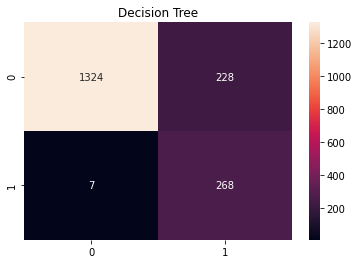

In [28]:
cm = metrics.confusion_matrix(y_test, y_pred_dtc)
sns.heatmap(cm, annot=True, fmt="d").set_title("Decision Tree")
plt.show()

In [29]:
cv_results = cross_val_score(dtc, X_train_down,y_train_down, cv = 5)
cv_results

array([0.91062802, 0.92251816, 0.91525424, 0.91041162, 0.9031477 ])

In [30]:
dtc_recall = recall_score(y_test, y_pred_dtc)
dtc_precision = precision_score(y_test,y_pred_dtc)
dtc_f1 = f1_score(y_test,y_pred_dtc)

print("dtc_recall is",(dtc_recall))
print("dtc_precision is",(dtc_precision))
print("dtc_f1_score is",(dtc_precision))

dtc_recall is 0.9745454545454545
dtc_precision is 0.5403225806451613
dtc_f1_score is 0.5403225806451613


Recall score is high, so we'll can focus on population that will offer the best convertion chances. Precision is quite low so we will certainly contact too much people labeled as converted but that will certainly not convert at the end.

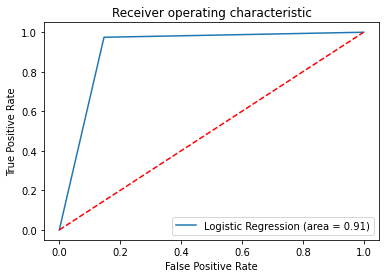

In [31]:
# ROC Curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, dtc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dtc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Randon Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_down, y_train_down)

y_pred_rfc = rfc.predict(X_test)

acc_train = rfc.score(X_train, y_train)*100
acc_test = rfc.score(X_test,y_test)*100

print("The accuracy score for the training data is: ",round(acc_train,2),"%")
print("The accuracy score for the test data is: ",round(acc_test,2),"%")

The accuracy score for the training data is:  95.1 %
The accuracy score for the test data is:  94.14 %


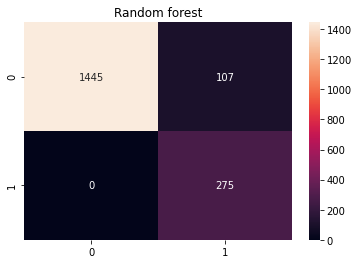

In [33]:
cm = metrics.confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(cm, annot=True, fmt="d").set_title("Random forest")
plt.show()

In [34]:
dtc_recall = recall_score(y_test, y_pred_rfc)
dtc_precision = precision_score(y_test,y_pred_rfc)
dtc_f1 = f1_score(y_test,y_pred_rfc)

print("recall is",(dtc_recall))
print("precision is",(dtc_precision))
print("f1_score is",(dtc_precision))

recall is 1.0
precision is 0.7198952879581152
f1_score is 0.7198952879581152


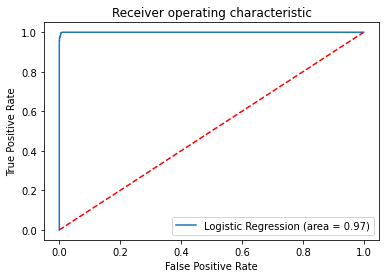

In [35]:
# ROC Curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, rfc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

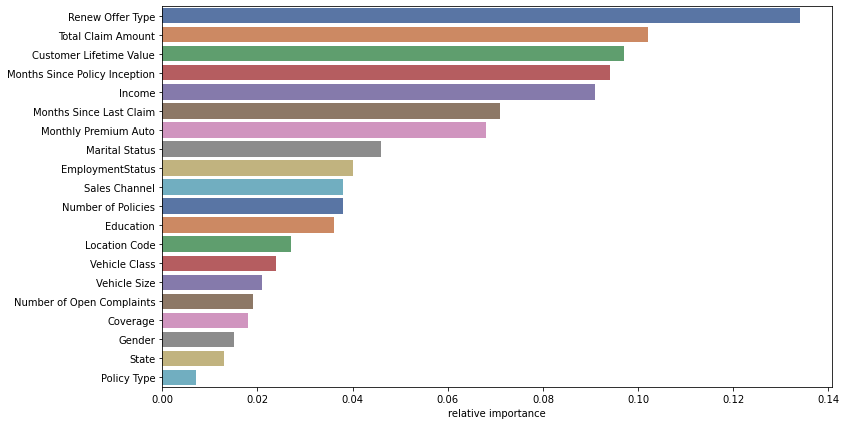

In [36]:
feature_imp = rfc.feature_importances_.round(3)
ser_rank = pd.Series(feature_imp, index=X.columns).sort_values(ascending = False)

plt.figure(figsize=(12,7))
sns.barplot(x= ser_rank.values, y = ser_rank.index, palette='deep')
plt.xlabel('relative importance')
plt.show()

## Randon Forest - classweight

In [37]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, class_weight="balanced")
rfc.fit(X_train_down, y_train_down)

y_pred_rfc = rfc.predict(X_test)

acc_train = rfc.score(X_train, y_train)*100
acc_test = rfc.score(X_test,y_test)*100

print("The accuracy score for the training data is: ",round(acc_train,2),"%")
print("The accuracy score for the test data is: ",round(acc_test,2),"%")

The accuracy score for the training data is:  95.7 %
The accuracy score for the test data is:  93.92 %


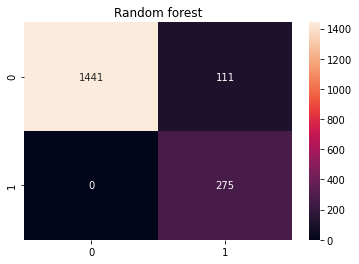

In [38]:
cm = metrics.confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(cm, annot=True, fmt="d").set_title("Random forest")
plt.show()

In [39]:
dtc_recall = recall_score(y_test, y_pred_rfc)
dtc_precision = precision_score(y_test,y_pred_rfc)
dtc_f1 = f1_score(y_test,y_pred_rfc)

print("recall is",(dtc_recall))
print("precision is",(dtc_precision))
print("f1_score is",(dtc_precision))

recall is 1.0
precision is 0.7124352331606217
f1_score is 0.7124352331606217


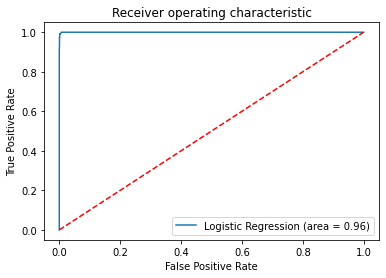

In [40]:
# ROC Curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, rfc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()